In [0]:
import tSmote as ts


import tensorflow as tf

from keras.regularizers import l2, l1

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, Concatenate, Average, Add, RepeatVector,TimeDistributed
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform, random_normal

import numpy as np
import random
np.random.seed(0)

import matplotlib.pyplot as plt

import pandas as pd
#from imblearn.over_sampling import SMOTENC

from collections import defaultdict


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc as AUC
from sklearn.neighbors import NearestNeighbors as NN

from sklearn.linear_model import LogisticRegression

from pyspark.sql import Row
from pyspark.sql.functions import col

import random 
from operator import add 
import math
import decimal
from scipy.signal import savgol_filter
from scipy.stats import levene

In [0]:
tf.__version__, np.__version__

Out[3]: ('2.8.0', '1.22.3')

## Generate 2D oscillator data

Out[47]:

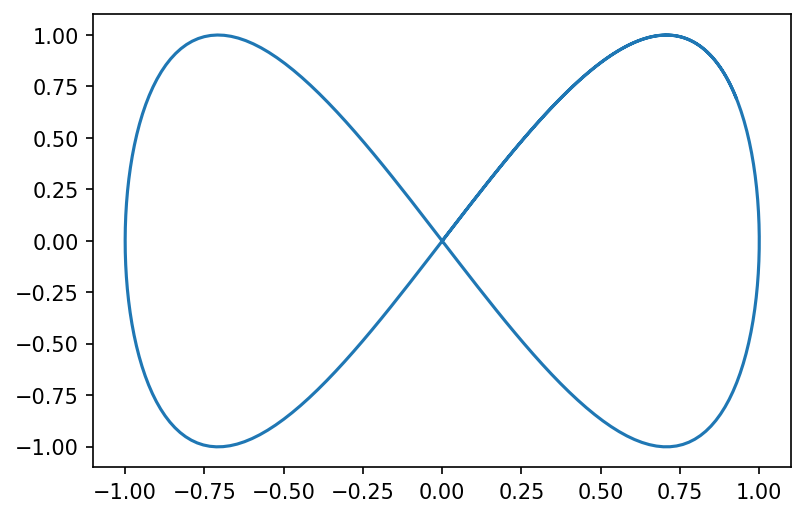

[<matplotlib.lines.Line2D at 0x7f72de4c1bb0>]

In [0]:
plt.figure(dpi=150)
omega_x=3
omega_y=6
std=.1
tMax=max([2*np.pi/omega_x,2*np.pi/omega_y])
nSamp=270
data=[]
tPoints=[]
i=0
while i < nSamp:
    nPoints=random.randrange(5,20)
#  tSet=np.random.exponential(tMax/3, size=nPoints).tolist()
    tSet=np.random.uniform(0, tMax, size=nPoints).tolist()
    tSet.sort()
    d=[[np.sin(omega_x*t)+random.gauss(0,std),np.sin(omega_y*t)+random.gauss(0,std)] for t in tSet]
  
    tPoints.append(tSet)
    data.append(d)
    i+=1
  
  #plt.scatter(d[:,0], d[:,1])
  #display(plt.show())
real=[[np.sin(omega_x*t/100),np.sin(omega_y*t/100)] for t in range(250) ]
xReal=[x[0] for x in real]
yReal=[x[1] for x in real]

plt.plot(xReal, yReal)
#plt.show()


plt.figure(dpi=150)
omega_x=3
omega_y=12
std=.1
tMax=max([2*np.pi/omega_x,2*np.pi/omega_y])
nSamp=180
data2=[]
tPoints2=[]
i=0
while i < nSamp:
    nPoints=random.randrange(5,20)
#  tSet=np.random.exponential(tMax/3, size=nPoints).tolist()
    tSet=np.random.uniform(0, tMax, size=nPoints).tolist()
    tSet.sort()
    d=[[np.sin(omega_x*t)+random.gauss(0,std),np.sin(omega_y*t)+random.gauss(0,std)] for t in tSet]
  
    tPoints2.append(tSet)
    data2.append(d)
    i+=1
  
  #plt.scatter(d[:,0], d[:,1])
  #display(plt.show())
maxT=max([max(t) for t in tPoints])

real=[[np.sin(omega_x*t/100),np.sin(omega_y*t/100)] for t in range(250) ]
xReal=[x[0] for x in real]
yReal=[x[1] for x in real]

plt.plot(xReal, yReal)
plt.show()



# tSMOTE usage: preparing data for imputation

In [0]:
# define bins over both classes
bins, dt=ts.getNonUniformTimeSliceBins(tPoints+tPoints2, 0, maxT,20)
#seperate back out classes and remove degenerate obvservations 
#i.e. consecutive observations which fall within the same time slice
data, tBins=ts.removeDegeneracies(data, bins[:len(tPoints)])
data2, tBins2=ts.removeDegeneracies(data2, bins[len(tPoints):])

# construct the time slies
tSlice=ts.getRawTimeSlice(data,tBins, 20)
tSlice2=ts.getRawTimeSlice(data2, tBins2, 20)

#generate the synthetic points 
tSyn=ts.generateTimePoints(tSlice, 300)
tSyn2=ts.generateTimePoints(tSlice2, 200)

In [0]:
tBins=bins[:len(tPoints)]
tBins2=bins[len(tPoints):]

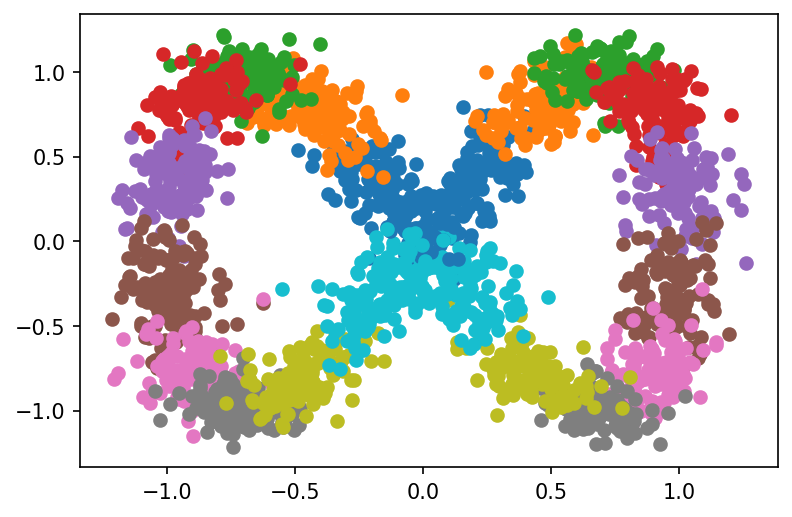

In [0]:
#compute the center of each time slice
times=[]
for i in range(len(dt)):
    t0=dt[0]
    if i==0:
        t=t0/2
    else:
        t1=sum(dt[:(i-1)])
        t=t1+dt[i]/2
    times.append(t)

#plot each time slice
plt.figure(dpi=150)
for T in tSlice:
    X=[x[0] for x in T]
    Y=[x[1] for x in T]
    plt.scatter(X,Y)
#display(fig1.show())
plt.show()

fig2, ax2=plt.subplots()
for T in tSlice2:
    X=[x[0] for x in T]
    Y=[x[1] for x in T]
    ax2.scatter(X,Y)
#display(fig2.show())
plt.show()

# test on a single sample and visualize

Out[63]:

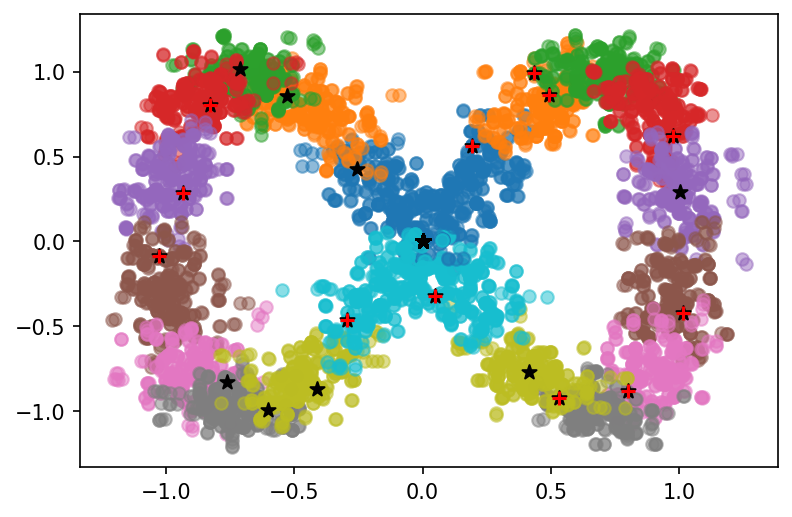

<matplotlib.collections.PathCollection at 0x7f72de039520>

In [0]:
samp=data[0]
tSamp=tBins[0]
k=10

X0=np.zeros(shape=(k,20,2))
for i in range(k):
    x01=ts.imputeMixed([samp],[tSamp],tSyn,nf=1,nb=1,nFix=0,nSubSamp=20,sig=1,K=0,mode='global', verbose=False)
    X0[i]=x01


plt.figure(dpi=150)
#X0=X0.mean(axis=0)
sampa=np.array(samp)
for t in tSyn:
    plt.scatter(np.array(t)[:,0], np.array(t)[:,1], alpha=.5)
plt.scatter(X0[:,:,0], X0[:,:,1], s=50, marker='*', color='black') #imputed trajectory
plt.scatter(sampa[:,0], sampa[:,1], s=50, marker='+', color='red') #real sample points

# run tSMOTE on whole set

In [0]:
#easy way to get the test data for the model
def getTestData():
    omega_x=3
    omega_y=6
    std=.1
    tMax=max([2*np.pi/omega_x,2*np.pi/omega_y])
    nSamp=30
    dataTest=[]
    tPointsTest=[]
    i=0
    while i < nSamp:
        d=[[np.sin(omega_x*t)+random.gauss(0,std),np.sin(omega_y*t)+random.gauss(0,std)] for t in times]

        dataTest.append(d)
        i+=1

    #plt.scatter(d[:,0], d[:,1])
    #display(plt.show())

    omega_x=3
    omega_y=12
    std=.1
    tMax=max([2*np.pi/omega_x,2*np.pi/omega_y])
    nSamp=20
    dataTest2=[]
    tPointsTest2=[]
    i=0
    while i < nSamp:
        d=[[np.sin(omega_x*t)+random.gauss(0,std),np.sin(omega_y*t)+random.gauss(0,std)] for t in times]

        dataTest2.append(d)
        i+=1

    return (dataTest,dataTest2)

In [0]:
X0=ts.imputeMixed(data,tBins,tSyn,nf=1,nb=1,nFix=0,nSubSamp=10,sig=1,K=0,mode='global', verbose=False)
X1=ts.imputeMixed(data2,tBins2,tSyn2,nf=1,nb=1,nFix=0,nSubSamp=10,sig=1,K=0,mode='global',verbose=False)
X0=X0.tolist()
X1=X1.tolist()

In [0]:
#X0=imputeMeanTimeSlices(data,tBins,tSyn)
#X1=imputeMeanTimeSlices(data,tBins,tSyn)


In [0]:
#X0=imputeMedianTimeSlices(data,tBins,tSyn)
#X1=imputeMedianTimeSlices(data,tBins,tSyn)

## run the model (apologizes for the messiness)

In [0]:
inT=30
outT=50
n_steps_in=30
n_features=2
n_steps_out=20
reg=10**(-4)
K=10 ### number of time to train the models
evaFull=np.zeros(shape=(K,10,4)) ### store the training metrics and validaiton
metTS=np.zeros(shape=(K,4)) ### store the test metrics
cmTS=np.zeros(shape=(K,2,2))
for M in range(K):
  
    xT, yT=getTestData()
  
    dataTest=xT
    tPointsTest=xT[1]
    
    dataTest2=yT
    tPointsTest2=yT[1]

#    X0=imputeMixed(data,tBins,tSyn,nf=10,nb=10,nFix=0,nSubSamp=20,sig=1,K=0,mode='global', verbose=False)
#    X1=imputeMixed(data2,tBins2,tSyn2,nf=10,nb=10,nFix=0,nSubSamp=20,sig=1,K=0,mode='global',verbose=False)
#    X0=X0.tolist()
#    X1=X1.tolist()

### local classifier =LR
#    predLayer=LogisticRegression(penalty='l1', C=1/reg, solver='liblinear')
  
### local classifier = MLP  
#    predLayer= Sequential()
#    predLayer.add(Dense(n_features, activation='relu'))
#    predLayer.add(Dense(n_features, activation='relu'))
#    predLayer.add(Dense(1, activation='sigmoid'))
#    predLayer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
  
### LSTM encoder/decoder for forecasting  
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features), kernel_regularizer=l2(.0001), recurrent_regularizer=l2(.0001)))
    model.add(RepeatVector(n_steps_out))
    model.add(Dropout(rate=.6))
    model.add(LSTM(50, activation='relu', return_sequences=True, kernel_regularizer=l2(.0001), recurrent_regularizer=l2(.0001)))
    model.add(Dropout(rate=.6))
    model.add(TimeDistributed(Dense(n_features,kernel_regularizer=l2(.0001) )))
    model.compile(optimizer='adam', loss='mse')

### global classifier = LSTM
    modelPred=Sequential()
    modelPred.add(LSTM(25, kernel_initializer='random_normal', input_shape=(n_steps_in+n_steps_out, n_features), kernel_regularizer=l1(.001), recurrent_regularizer=l1(.001)))
    modelPred.add(Dense(2,kernel_initializer='random_normal', activation='sigmoid'))
    modelPred.compile(optimizer='adam', loss='binary_crossentropy',metrics=['AUC', 'accuracy'])
    
### my own k-fold validation code + normalization. feel free to modify and use your own.
    dataTS=[[x,0] for x in X0]+[[x,1] for x in X1]
    random.shuffle(dataTS)
    normDataIn=[]
    normDataOut=[]
    eva=[]
  #initial split of training vs. test
    testData=[[x,0] for x in dataTest]+[[x,1] for x in dataTest2]
    random.shuffle(testData)
    mod0s=[x for x in dataTS if x[1]==0]
    mod1s=[x for x in dataTS if x[1]==1]
    print(len(mod0s), len(mod1s))
    mod=random.sample(mod0s, len(mod1s))+mod1s
    random.shuffle(mod)

    kFoldList=partition(mod, 10) 

    inMod=np.zeros(shape=(len(mod), 30, 2))
    outMod=np.zeros(shape=(len(mod), 20, 2))
    for i in range(len(inMod)):
        inMod[i]=mod[i][0][:n_steps_in]
        outMod[i]=mod[i][0][n_steps_in:n_steps_in +n_steps_out]

    meanIn=inMod.mean(axis=0)
    meanOut=outMod.mean(axis=0)

    stdIn=inMod.std(axis=0)
    stdOut=outMod.std(axis=0)



    print('Training model...')
    for k in range(len(kFoldList)):
        print(' ')
    if k==0:
        print('Starting {}st pass'.format(k+1))
    elif k==1:
        print('Starting {}nd pass'.format(k+1))
    elif k==2:
        print('Starting {}rd pass'.format(k+1))
    else:
        print('Starting {}th pass'.format(k+1))
    print(' ') 
        valid=[v for v in mod if v not in kFoldList[k]]
        Xtrain=[x[0][:inT] for x in valid]
        Ytrain=[y[0][inT:outT] for y in valid]
        YtrainLR=np.array([x[1] for x in valid])

        Xvalid=[x[0][:inT] for x in kFoldList[k]]
        Yvalid=[y[0][inT:outT] for y in kFoldList[k]]
        YvalidLR=np.array([x[1] for x in kFoldList[k]])


        inp=np.zeros(shape=(len(Xtrain), 30, 2))
        out=np.zeros(shape=(len(Ytrain), 20, 2))
        inpTest=np.zeros(shape=(len(Xvalid), 30, 2))
        outTest=np.zeros(shape=(len(Yvalid), 20, 2))
        print('woot')
        print(' ')
        for i in range(len(inp)):
            inp[i]=Xtrain[i]
            out[i]=Ytrain[i]
        for i in range(len(inpTest)):
            inpTest[i]=Xvalid[i]
            outTest[i]=Yvalid[i] 
        print('woot woot')
        print(' ')


        for i in range(len(inp)):
            inp[i]=(inp[i]-meanIn)/stdIn     
            out[i]=(out[i]-meanOut)/stdOut

        for i in range(len(inpTest)):
            inpTest[i]=(inpTest[i]-meanIn)/stdIn          
            outTest[i]=(outTest[i]-meanOut)/stdOut

### training the LR clasifier

#    XtrainLR=np.array([x[-1] for x in out])
#    XvalidLR=np.array([x[-1] for x in outTest])

#    predLayer.fit(XtrainLR, YtrainLR)
#    ypred=predLayer.predict(XvalidLR)
#    ypred=[1 if x>.5 else 0 for x in ypred]
#    outLR = predLayer.evaluate(XvalidLR, YvalidLR)
#    outLR=predLayer.score(XvalidLR, YvalidLR)
#    cm=confusion_matrix(YvalidLR, ypred, normalize='true')
#    print(f'LR test acc: {outLR}')
#    print(' ')
#    print(f'LR test confusion_matrix: {cm}')
#    print(' ')

### fit the encoder/decoder
    model.fit(inp, out, batch_size = 64, epochs=25, verbose=0)
    trainPred=model.predict(inp)
    
## construct and train the LSTM classifier    
        X2=np.concatenate((inp,out), axis=1)
        yTrainOH=np.array([[1,0] if x==0 else [0,1] for x in YtrainLR])
        print(X2.shape, yTrainOH.shape)

        modelPred.fit(X2,yTrainOH, batch_size = 8, epochs=10, verbose=1)

        testPred=model.predict(inpTest)
        X2=np.concatenate((inpTest,outTest), axis=1)
        yValOH=np.array([[1,0] if x==0 else [0,1] for x in YvalidLR])
        
### evaluate the loss/metrics of the classifier           
        outLR=modelPred.evaluate(X2,yValOH)
    
#    outLR = predLayer.evaluate(XvalidLR, YvalidLR)
    
  

    ### evaluate the loss of the encoder/decoder    
        l = model.evaluate(inpTest, outTest, verbose=0)
    
        outLR.append(l)


        print(f'LSTM Test Loss: {l}')
        evaFull[M,k,:]=outLR 



    Xtest=[x[0][:inT] for x in testData]
    Ytest=[y[0][inT:outT] for y in testData]
    Y=np.array([x[1] for x in testData])

    inpT=np.zeros(shape=(len(Xtest), 30, 2))
    outTT=np.zeros(shape=(len(Ytest), 20, 2))
    for i in range(len(inpT)):
        inpT[i]=Xtest[i]
        outTT[i]=Ytest[i]
    for j in range(len(inpT)):
        inpT[j]=(inpT[j]-meanIn)/stdIn          
        outTT[j]=(outTT[j]-meanOut)/stdOut

    valPred=model.predict(inpT)
  
    X2=np.concatenate((inpT,valPred), axis=1)
    yValOH=np.array([[1,0] if x==0 else [0,1] for x in Y])
    
    scoreLR = modelPred.evaluate(X2, yValOH)
  
    X=np.array([testPred[i][-1] for i in range(len(testPred))])

    L=model.evaluate(inpT, outTT, verbose=0)

    print(f' LSTM validation loss: {L}')
    print(' ')
    scoreLR.append(L)
    
### validation for the local classifiers    
#  predLR=predLayer.predict(X)
#  predLR=[1 if x>.5 else 0 for x in predLR]
#  scoreLR=predLayer.evaluate(X,Y)
#  scoreLR.append(L)
#  scoreLR=predLayer.score(X,Y)
#  cm1=confusion_matrix(Y,predLR)
#  cmp=plot_confusion_matrix(LR,X,Y)
#  auc=roc_auc_score(Y, predLR)
#  print(f'AUC is {auc}')
#  display(plt.show())
#  print(f'LR validation acc: {scoreLR}')
#  print(' ')

#  print(f'LR validation confusion matrix: {cm1}')
#  cmTS[M,:,:]=cm1

#  metTS[M,:]=[scoreLR, auc,L,np.nan]
    metTS[M,:]=scoreLR


print(cmTS.mean(axis=0), cmTS.std(axis=0))
print(metTS.mean(axis=0), metTS.std(axis=0))


270 180
Training model...
 
Starting 1st pass
 
woot
 
woot woot
 
 
 
(324, 50, 2) (324, 2)
Epoch 1/10
 1/41 [..............................] - ETA: 1:31 - loss: 0.8982 - auc: 0.5547 - accuracy: 0.6250 3/41 [=>............................] - ETA: 1s - loss: 0.8945 - auc: 0.6302 - accuracy: 0.7500  6/41 [===>..........................] - ETA: 0s - loss: 0.8907 - auc: 0.6387 - accuracy: 0.7083 9/41 [=====>........................] - ETA: 0s - loss: 0.8865 - auc: 0.6742 - accuracy: 0.750012/41 [=======>......................] - ETA: 0s - loss: 0.8826 - auc: 0.6836 - accuracy: 0.739615/41 [=========>....................] - ETA: 0s - loss: 0.8787 - auc: 0.6911 - accuracy: 0.733318/41 [============>.................] - ETA: 0s - loss: 0.8748 - auc: 0.7275 - accuracy: 0.736121/41 [==============>...............] - ETA: 0s - loss: 0.8708 - auc: 0.7546 - accuracy: 0.738124/41 [================>.............] - ETA: 0s - loss: 0.8673 - auc: 0.7595 - accuracy: 0.760427/41 [==================>...........] - ETA: 0s - loss: 0.8636 - auc: 0.7576 - accuracy: 0.763930/41 [====================>.........] - ETA: 0s - loss: 0.8600 - auc: 0.7748 - accuracy: 0.766733/41 [=======================>......] - ETA: 0s - loss: 0.8564 - auc: 0.7911 - accuracy: 0.772736/41 [=========================>....] - ETA: 0s - loss: 0.8532 - auc: 0.7841 - accuracy: 0.760439/41 [===========================>..] - ETA: 0s - loss: 0.8501 - auc: 0.7796 - accuracy: 0.756441/41 [==============================] - 3s 19ms/step - loss: 0.8482 - auc: 0.7812 - accuracy: 0.7531
Epoch 2/10
 1/41 [..............................] - ETA: 0s - loss: 0.7942 - auc: 0.9688 - accuracy: 0.8750 4/41 [=>............................] - ETA: 0s - loss: 0.7950 - auc: 0.9199 - accuracy: 0.7812 7/41 [====>.........................] - ETA: 0s - loss: 0.7933 - auc: 0.8881 - accuracy: 0.785710/41 [======>.......................] - ETA: 0s - loss: 0.7916 - auc: 0.8495 - accuracy: 0.750013/41 [========>.....................] - ETA: 0s - loss: 0.7880 - auc: 0.8640 - accuracy: 0.778816/41 [==========>...................] - ETA: 0s - loss: 0.7856 - auc: 0.8673 - accuracy: 0.7969

In [0]:
metTS

Out[94]: array([[0.04177465, 1. , 1. , 1.94894838],
 [0.08839121, 1. , 1. , 1.94273603],
 [0.02750797, 0.99999994, 1. , 1.92536557],
 [0.07298677, 0.99959993, 0.98000002, 2.0405407 ],
 [0.07092107, 1. , 1. , 1.93808711],
 [0.05638622, 1. , 1. , 1.93400025],
 [0.02880504, 0.99999994, 1. , 1.8468616 ],
 [0.08885811, 1. , 1. , 1.99774504],
 [0.03842905, 1. , 1. , 2.04276156],
 [0.02802213, 1. , 1. , 1.90544033]])

In [0]:
metTS.mean(axis=0)

Out[132]: array([0.05420822, 0.99995998, 0.998 , 1.95224866])

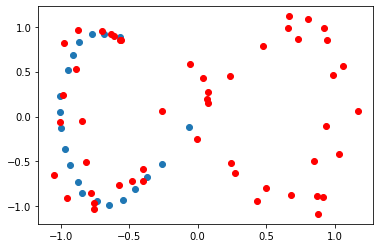

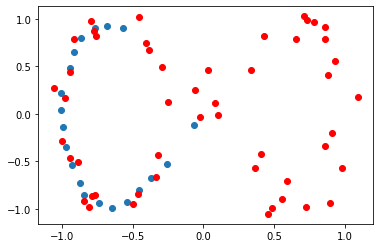

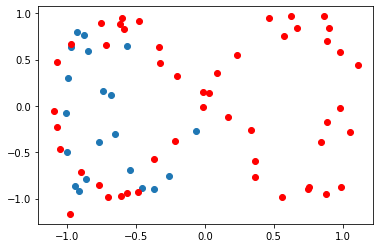

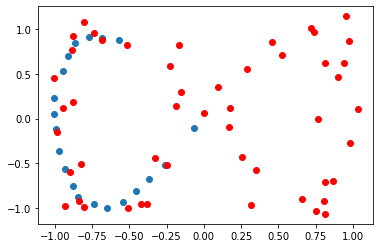

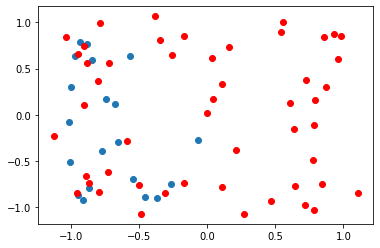

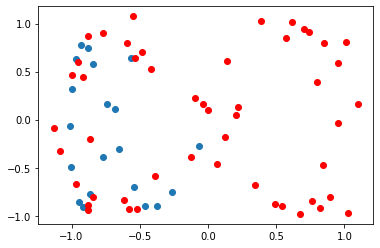

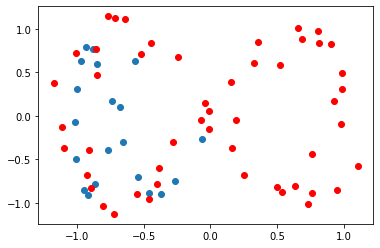

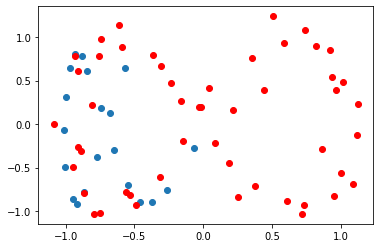

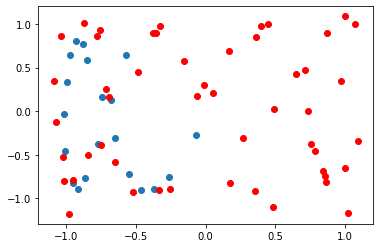

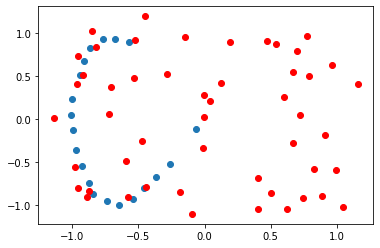

In [0]:
## visualize the predictions
for i in range(10):  
    t=testPred[i]*stdOut+meanOut
    ttI=inpT[i]*stdIn+meanIn
    ttO=outTT[i]*stdOut+meanOut
    tt=np.concatenate((ttI,ttO), axis=0)
    plt.scatter(t[:,0], t[:,1])
    plt.scatter(tt[:,0], tt[:,1], c='red')
    plt.show()